In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (74).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (11).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (78).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/rendang_valid_20.jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (8).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (12).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (72).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (76).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (77).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (6).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (13).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (9).jpg
/kaggle/input/dataset-10/Dataset/Valid/daging rendang/daging_rendang (

In [2]:
#Import library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Ditemukan GPU di: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("Tidak ada GPU , menggunakan {}.".format(device_name))

Ditemukan GPU di: /device:GPU:0


In [4]:
train_dir = "/kaggle/input/dataset-10/Dataset/Train"
val_dir = "/kaggle/input/dataset-10/Dataset/Valid"
test_dir = "/kaggle/input/dataset-10/Dataset/Test"

**PREPROCESSING**

In [5]:
#Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    rotation_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)

In [6]:
#Declare size & Batch
train_batch_size = 30
val_batch_size = 30
test_batch_size = 30
img_height = 150
img_width = 150

In [7]:
train_ds = train_generator.flow_from_directory(
    directory = train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = train_batch_size,
    shuffle = True,
    seed = 42,
)

val_ds = val_generator.flow_from_directory(
    directory = val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = val_batch_size,
    shuffle = True,
    seed = 42,
)

test_ds = test_generator.flow_from_directory(
    directory = test_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = test_batch_size,
    shuffle = False
)

Found 787 images belonging to 10 classes.
Found 202 images belonging to 10 classes.
Found 84 images belonging to 10 classes.


In [8]:
#Display class
class_names = train_ds.class_indices
print(class_names)

{'ayam goreng': 0, 'capcay': 1, 'daging rendang': 2, 'gudeg': 3, 'mie goreng': 4, 'nasi goreng': 5, 'sate ayam': 6, 'soto lamongan': 7, 'tahu sumedang': 8, 'tempe goreng': 9}


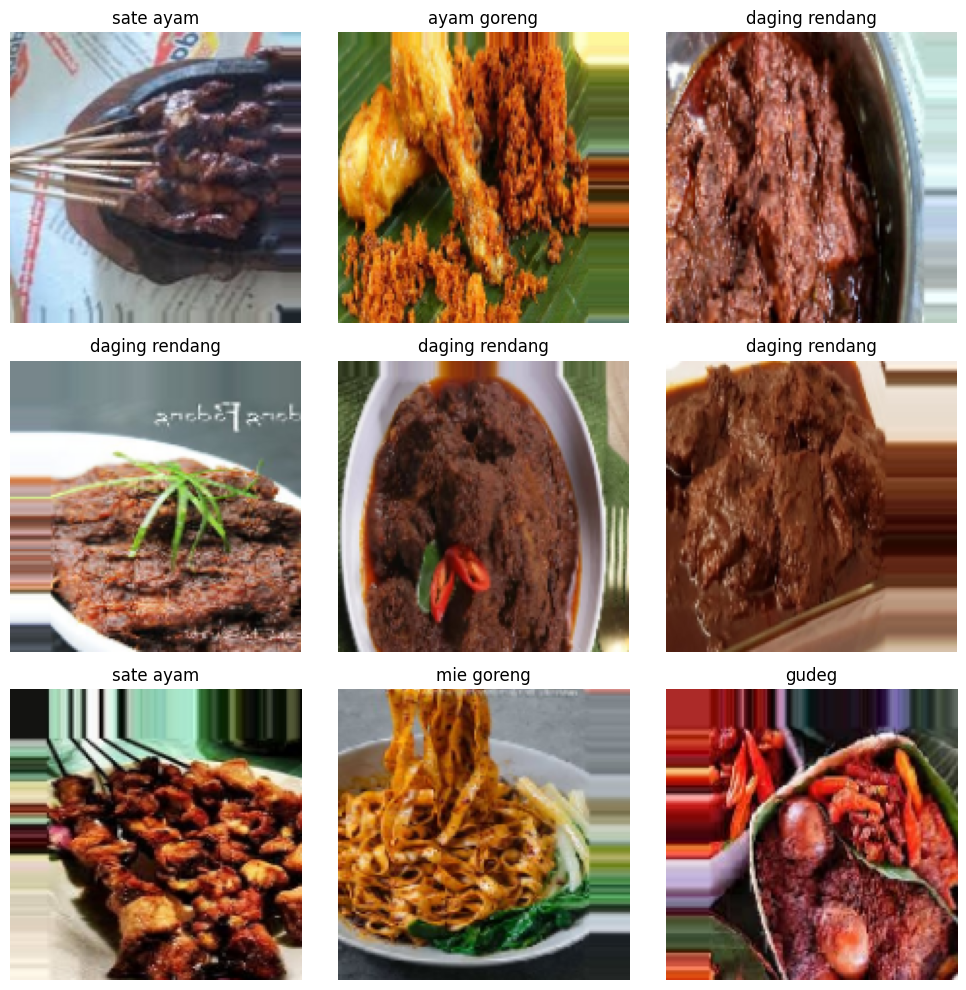

In [9]:
# Fetch the first batch of images and labels from train_ds
images, labels = next(train_ds)

# Display the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Retrieve the label index from the one-hot encoded format
    label_index = np.argmax(labels[i])

    # Get the class name corresponding to the label index
    for class_name, index in train_ds.class_indices.items():
        if index == label_index:
            plt.title(class_name)
            break

    plt.axis("off")

plt.tight_layout()
plt.show()

**MAKE THE MODELS**

In [10]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

96112376/96112376 [==============================] - 0s 0us/step


In [11]:
# Adding more layer in top of based model for fine tuning
inputs = pre_trained_model.input

x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Increase dropout

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [12]:
# Set callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93:
                print("\nReached 87% accuracy in training and validation. Stopping training.")
                self.model.stop_training = True
                print(logs)

callbacks = myCallback()

In [13]:
# Set training parameters
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics = ['acc'])

In [14]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 98% accuracy
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 5,
                    callbacks = [callbacks])

Epoch 1/5
27/27 [==============================] - 62s 620ms/step - loss: 2.3029 - acc: 0.0915 - val_loss: 2.3023 - val_acc: 0.1238
Epoch 2/5
27/27 [==============================] - 10s 383ms/step - loss: 2.3021 - acc: 0.1042 - val_loss: 2.3021 - val_acc: 0.0842
Epoch 3/5
27/27 [==============================] - 10s 359ms/step - loss: 2.3013 - acc: 0.1156 - val_loss: 2.3012 - val_acc: 0.0792
Epoch 4/5
27/27 [==============================] - 10s 372ms/step - loss: 2.3006 - acc: 0.1220 - val_loss: 2.3007 - val_acc: 0.1139
Epoch 5/5
27/27 [==============================] - 10s 370ms/step - loss: 2.3000 - acc: 0.1410 - val_loss: 2.2997 - val_acc: 0.1287


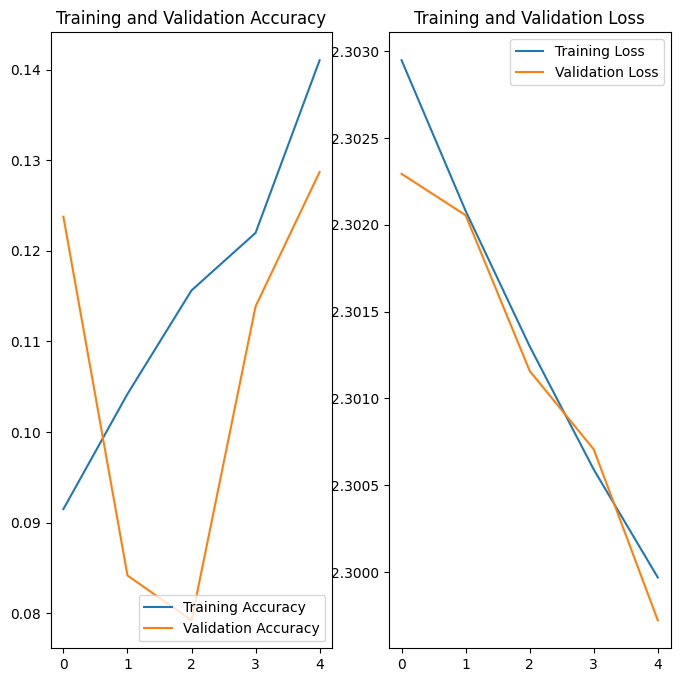

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/3 [===================>..........] - ETA: 0s

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 803ms/step
y_pred: [2 9 0 6 2 2 2 3 9 6 2 5 5 5 2 6 5 6 2 5 2 6 9 7 2 7 7 6 2 2 2 5 2 2 3 2 5
 5 2 5 5 6 5 2 6 3 2 2 7 6 9 3 6 2 7 7 7 7 6 7 6 2 2 2 2 5 6 6 5 6 3 7 2 2
 2 5 5 2 6 5 2 5 5 6]
y_true: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8
 8 8 8 8 8 9 9 9 9 9]


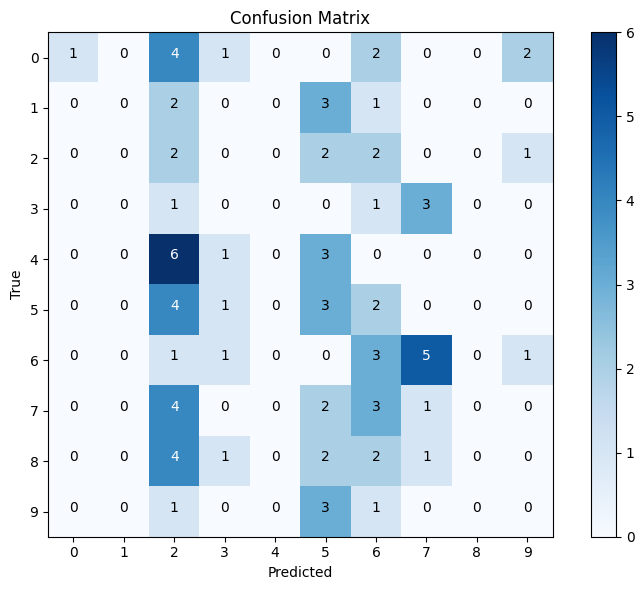


F1 Score: 0.09638047138047137


In [16]:
# Mendapatkan prediksi dari model pada data uji
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan label sebenarnya dari data uji
y_true = test_ds.classes

# Print y_pred and y_true
print("y_pred:", y_pred)
print("y_true:", y_true)

# Membuat confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix menggunakan matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = len(np.unique(y_true))
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

plt.xlabel('Predicted')
plt.ylabel('True')

# Menambahkan angka di dalam kotak confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, confusion[i, j],
                 horizontalalignment='center',
                 color='white' if confusion[i, j] > (confusion.max() / 2) else 'black')

plt.tight_layout()
plt.show()

# Menghitung F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nF1 Score:", f1)

In [17]:
import numpy as np
from PIL import Image
from keras.preprocessing import image

# Path to your image
image_path = "/kaggle/input/dataset-10/Dataset/Test/soto lamongan/c7b758734c93204823d947c377c9a6be.jpg"  # Update with your image path

img = Image.open(image_path)
img = img.resize((299, 299))  # Resize the image to the required size
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

classes = model.predict(img_array, batch_size=20)
predicted_ids = np.argmax(classes, axis=-1)

# Print y_pred and y_true for inference
print("y_pred:", int(predicted_ids))
print("y_true:", test_ds.class_indices['soto lamongan'])  # Assuming 'soto lamongan' is the actual label

category = ['ayam goreng', 'capcay', 'daging rendang', 'gudeg', 'mie goreng', 'nasi goreng', 'sate ayam', 'soto lamongan', 'tahu sumedang', 'tempe goreng']
result = "{} is {}".format(image_path, category[int(predicted_ids)])
print(image_path)
print(int(predicted_ids))
print(result)

1/1 [==============================] - 3s 3s/step
y_pred: 6
y_true: 7
/kaggle/input/dataset-10/Dataset/Test/soto lamongan/c7b758734c93204823d947c377c9a6be.jpg
6
/kaggle/input/dataset-10/Dataset/Test/soto lamongan/c7b758734c93204823d947c377c9a6be.jpg is sate ayam


In [18]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

model.save('/kaggle/working/balanzio_mobilenetv2_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
